In [ ]:
using Revise
import SSD

In [2]:
using CPUTime
using CSV
using DataFrames
using Dates
using DelimitedFiles
using Distributions
using Distances
using Gurobi
using LinearAlgebra
using Plots
using Random

In [ ]:
using TimerOutputs

# Create a TimerOutput, this is the main type that keeps track of everything.
const to = TimerOutput()

In [ ]:
function get_res(file)
    extract = false
    instance = ""
    method = ""
    lb = -99
    ub = -99
    cpu_t = -99
    status = ""
    iter = -99
    mess = ""
    backup = ""
    i=1
    open(file,"r") do f  
        while !eof(f)
            line = readline(f)
            sline = split(line)
            if i == 7
                backup = line
            end
            if size(sline)[1] > 0
                if extract==true
                    if sline[1] == "Instance:"
                        instance = split(split(sline[2], "/")[end],".")[1]
                    elseif sline[1] == "Method:"
                        method = sline[2]
                    elseif sline[1] == "LB:"
                        lb = parse(Float64,sline[2])
                    elseif sline[1] == "UB:"
                        ub = parse(Float64,sline[2])
                    elseif sline[1] == "CPU_t:"
                        cpu_t = parse(Float64,sline[2])
                    elseif sline[1] == "Status:"
                        status = sline[2]
                    elseif sline[1] == "Iter:"
                        iter = parse(Float64,sline[2])
                    end
                end
                if sline[1] == "RESULTS"                
                    extract = true
                end
                if sline[1] == "slurmstepd:"
                    println(file)
                    mess = join(sline[end-2:end-1]," ")
                    if backup != ""
                        bk = split(backup,":")
                        instance = split(bk[2],",")[1]
                        method=bk[end]
                        println(bk)
                        println(instance)
                        println(method)
                    end
                    return instance, method, lb, ub, cpu_t, status, iter, mess
                end
            end
            i+=1
        end
    end
    return instance, method, lb, ub, cpu_t, status, iter, mess
end

In [ ]:
df_res1 = DataFrame(inst=String[], method=String[], lb=Float64[], ub=Float64[], cpu_t=Float64[],status=String[],iter=Float64[], error=String[])
directory = "results/"
files = readdir(directory)
for filename in files
# filename = "ssd_1218114_1.out"
    # println(filename)
    instance, method, lb, ub, cpu_t, status, iter, mess = get_res(directory*filename)
    push!(df_res1, (instance, method, lb, ub, cpu_t, status, iter, mess));
end

In [ ]:
sort!(df_res1,[:inst])

In [ ]:
CSV.write("results/results.csv",df_res1)

In [ ]:
function extract_pmed(file)
    open(file,"r") do f        
        line = readline(f)
        sline = split(line)
        nJ = parse(Int64,sline[2])
        nI = parse(Int64,sline[1]) - nJ
        Icoords = Matrix{Float64}(undef, 2, nI)
        Jcoords = Matrix{Float64}(undef, 2, nJ)
        i = 1
        do_J = true
        while !eof(f)
            line = readline(f)
            sline = split(line)
            if do_J
                Jcoords[1,i] = parse(Float64,sline[1])
                Jcoords[2,i] = parse(Float64,sline[2])
                if i == nJ
                    i = 0
                    do_J = false
                end
            else
                Icoords[1,i] = parse(Float64,sline[1])
                Icoords[2,i] = parse(Float64,sline[2])
            end
            i += 1
        end
        return nI, nJ, Icoords, Jcoords
    end    
end

In [ ]:
df = DataFrame(id=Int[], in_type=String[], nI=Int[], nJ=Int[], cv=Float64[], D=Int[], FLR=Float64[], FCR=Int[])

params0 = SSD.default_params()
data = SSD.default_data()

coords_bounds=(0,100)
r_bounds=(0.3, 0.4)
k=5
t=3
a_bounds=(80,120)

id = 1

in_type = "Own"
for (nI, nJ) in [(20,3), (50,10), (70,50)]
    for cv in [0.5, 1, 1.5]
        for D in [1, 10, 25, 50, 100]
            for FLR in [0.4, 0.6, 0.8]
                for FCR in [2,4,8,10]
                    push!(df, (id, in_type, nI, nJ, cv, D, FLR, FCR));
                    SSD.instance_gen(id, in_type, nI, nJ, coords_bounds, a_bounds, r_bounds, cv, D, k, t, FLR, FCR, params0)
                    id += 1
                end
            end
        end
    end
end

in_type = "p-med"
directory = "instances/p-median/"
                # (90,10)   (185,15)        (275,25)     (372,30)      (2338, 700)
for filename in ["SJC1.dat", "SJC2.dat", "SJC3a.dat", "SJC4a.dat"]#, "p3038_700.dat"]
    file = directory*filename
    nI, nJ, Icoords, Jcoords = extract_pmed(file)
    for cv in [0.5, 1, 1.5]
        for D in [1, 10, 25, 50, 100]
            for FLR in [0.4, 0.6, 0.8]
                for FCR in [2,4,8,10]
                    push!(df, (id, in_type, nI, nJ, cv, D, FLR, FCR));
                    SSD.instance_gen(id, in_type, nI, nJ, coords_bounds, a_bounds, r_bounds, cv, D, k, t, FLR, FCR, params0, Icoords, Jcoords)
                    id += 1
                end
            end
        end
    end
end

In [ ]:
CSV.write("instances/instances inventory.csv",df)

In [ ]:
df = DataFrame(id=Int[], in_type=String[], nI=Int[], nJ=Int[], cv=Float64[], D=Int[], FLR=Float64[], FCR=Int[])

params0 = SSD.default_params()
data = SSD.default_data()

coords_bounds=(0,100)
r_bounds=(0.3, 0.4)
k=5
t=3
a_bounds=(80,120)

id = 1

in_type = "Own"
for (nI, nJ) in [(20,3), (70,10), (250,10)]
    for cv in [0.5, 1, 1.5]
        for D in [55000, 72500]
            for FLR in [0.6]
                for FCR in [8]
                    push!(df, (id, in_type, nI, nJ, cv, D, FLR, FCR));
                    SSD.instance_gen(id, in_type, nI, nJ, coords_bounds, a_bounds, r_bounds, cv, D, k, t, FLR, FCR, params0)
                    id += 1
                end
            end
        end
    end
end

In [ ]:
# params0 = SSD.default_params()
# data = SSD.default_data()

# coords_bounds=(0,100)
# r_bounds=(0.3, 0.4)
# k=5
# t=3
# a_bounds=(80,120)

# for cv in [0.5, 1, 1.5]
#     for D in [1, 10, 25, 50, 100]
#             SSD.instance_gen(10, 3, coords_bounds, a_bounds, r_bounds, cv, D, k, t, 0.4, 2, params0)
#     end
# end

# Solve 1 inst

In [115]:
directory = "instances/Own/"#p-med
filename="18_3.txt" #"6.txt"#"18_3.txt" # 404 - 235 - 130 - 200 - pmed 600

"18_3.txt"

In [325]:
params0 = SSD.default_params()
# params0.max_time = 60*5
data0 = SSD.default_data()

# Iterate over each instance
SSD.read_file(directory*filename, data0)

# Define the different cost levels
cost_levels = [0.60, 0.85, 1, 1.15, 1.35]
data0.F = SSD.gen_costs(data0, params0, cost_levels)
# Define the different capacity levels
cap_levels = [0.5, 0.75, 1, 1.25, 1.5]
data0.Q = SSD.gen_caps(data0, params0, cap_levels)


solve_method = "lazy_cuts"#"nlp"#"heur_LS"#"iter_cuts"#"lazy_cuts"#"bendersWS"#"heur_NM"#"heur_FB" "heur_NM" - bendersPK
println("Starting $solve_method")
status = SSD.init_solver_status()
el = @CPUelapsed res = SSD.solve_ssd(data0, params0, status, solve_method)
if solve_method == "iter_cuts"
    println("$solve_method: lb=$(res[1]), ub=$(res[2]),
        of_term1_lb=$(res[3]), of_term2_lb=$(res[4]), of_term3_lb=$(res[5]),
        of_term1_ub=$(res[6]), of_term2_ub=$(res[7]), of_term3_ub=$(res[8]),
        y=$(res[9]), CPU_t=$el")
elseif solve_method in ["benders", "bendersWS1", "bendersWS2", "bendersMW", "bendersPK", "bendersSH", "bendersFC", "bendersIter","bendersIterPK"]
    println("$solve_method: of=$(res[2]), of_term1=$(res[3]), of_term2=$(res[4]), of_term3=$(res[5]), y=$(res[6]), CPU_t=$el, nodes=$(res[9]),
        feas=$(res[10]), opt=$(res[11])")
else
    println("$solve_method: of=$(res[2]), of_term1=$(res[3]), of_term2=$(res[4]), of_term3=$(res[5]), y=$(res[6]), CPU_t=$el")
end
# 5951


instance file instances/Own/18_3.txt parsed successfully

Starting lazy_cuts
Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-18
Set parameter MIPGap to value 1e-05
Set parameter MIPFocus to value 2
Set parameter LazyConstraints to value 1
Set parameter Threads to value 1
Set parameter TimeLimit to value 10800.999
OPTIMAL
lazy_cuts: of=7545.4853, of_term1=2397.9837, of_term2=4276.7046, of_term3=870.797, y=2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, 1:10
    Dimension 2, 1:5
And data, a 10×5 Matrix{Float64}:
 -0.0                    -0.0                      0.0                     -0.0                 -0.0
 -0.0                    -0.0                     -0.0                      0.0                  1.0
 -0.0                     1.6392365652618386e-17   3.0708495407702616e-17   1.0000000000000042  -1.0017268083031575e-18
 -0.0                    -0.0                     -0.0                     -0.0            

In [ ]:
bendersIter: of=9616.535, of_term1=1481.9548, of_term2=5378.6252, of_term3=2755.955, y=Any[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], CPU_t=71.984, nodes=100,
        feas=9, opt=342

# Test the last solution before cutting the opt

In [242]:
y_lc = [0.0                 0.0  0.0  0.0                  0.07046327878761711
 0.8811798573171088  0.0  0.0  0.11872014268289122  0.0
 0.0                 0.0  0.0  0.37735158344417347  0.0
 0.4575968159219817  0.0  0.0  0.0                  0.0
 0.0                 0.0  0.0  0.7154095266087911   0.0
 0.6280647034507899  0.0  0.0  0.3502818230377037   0.02155347351150641
 0.0                 0.0  0.0  0.0                  0.2620957644315876
 0.0                 0.0  0.0  0.5164543859528121   0.0
 0.9077328141930615  0.0  0.0  0.0                  0.0
 0.0                 0.0  0.0  0.18701783221662024  0.0]

10×5 Matrix{Float64}:
 0.0       0.0  0.0  0.0       0.0704633
 0.88118   0.0  0.0  0.11872   0.0
 0.0       0.0  0.0  0.377352  0.0
 0.457597  0.0  0.0  0.0       0.0
 0.0       0.0  0.0  0.71541   0.0
 0.628065  0.0  0.0  0.350282  0.0215535
 0.0       0.0  0.0  0.0       0.262096
 0.0       0.0  0.0  0.516454  0.0
 0.907733  0.0  0.0  0.0       0.0
 0.0       0.0  0.0  0.187018  0.0

In [244]:
sum(y_lc, dims=2)

10×1 Matrix{Float64}:
 0.07046327878761711
 0.9999
 0.37735158344417347
 0.4575968159219817
 0.7154095266087911
 0.9999
 0.2620957644315876
 0.5164543859528121
 0.9077328141930615
 0.18701783221662024

In [233]:
# α_30
sum(α_30)

4091.0

In [239]:
# SP cost y_30
6395.785210791308 + 852.5168192748004

7248.302030066108

In [232]:
y_29=[0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.698778237247404
 0.0  0.0  0.0  0.0  0.2635014731044541
 0.0  0.0  0.0  0.0  0.5645293460653071
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.49866967830691317
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.35852523306595147
 0.0  0.0  0.0  0.0  0.81599603220997]

y_30=[0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.5601911301784772
 0.0  0.0  0.0  0.0  0.11666941574076958
 0.0  0.0  0.0  0.0  0.492109610861508
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.6356529691848739
 0.0  0.0  0.0  0.0  0.5449427033118036
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.49461201775465474
 0.0  0.0  0.0  0.0  0.3558221529679134]

α_30 = [1369.0
 1360.0
 1362.0]

y_31=[0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.772776389567251
 0.0  0.0  0.0  0.0  0.32326293286924823
 0.0  0.0  0.0  0.0  0.5579205409012574
 0.0  0.0  0.0  0.0  0.12428740932407338
 0.0  0.0  0.0  0.0  0.5248898725356463
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.55656133180242
 0.0  0.0  0.0  0.0  0.1707542483848666
 0.0  0.0  0.0  0.0  0.16954727461523725]

10×5 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.772776
 0.0  0.0  0.0  0.0  0.323263
 0.0  0.0  0.0  0.0  0.557921
 0.0  0.0  0.0  0.0  0.124287
 0.0  0.0  0.0  0.0  0.52489
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.556561
 0.0  0.0  0.0  0.0  0.170754
 0.0  0.0  0.0  0.0  0.169547

In [227]:
dot(data0.F, y_29), dot(data0.F, y_30), dot(data0.F, y_31)

(965.2433677820261, 969.6998529881532, 991.9098974962035)

In [235]:
y_cur = [0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.5601911301784772
 0.0  0.0  0.0  0.0  0.11666941574076958
 0.0  0.0  0.0  0.0  0.492109610861508
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.6356529691848739
 0.0  0.0  0.0  0.0  0.5449427033118036
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.49461201775465474
 0.0  0.0  0.0  0.0  0.3558221529679134]
α_cur = [1369.0
 1360.0
 1362.0];

In [234]:
dot(data0.F, y_30) + sum(α_30)

5060.699852988153

In [176]:
sum(α_cur)

4091.0

In [220]:
6161.170660114119+ 1288.5967718178247

7449.767431931943

In [236]:
I = 1:data0.I
J = 1:data0.J
λ = data0.a
C = data0.C
F = data0.F
Q = data0.Q
cv = data0.cv
D = data0.D    
K = 1:data0.k
T = 1:data0.t

1:3

In [252]:
y_cur = [0.0                 0.0  0.0  0.0                  0.07046327878761711
 0.8811798573171088  0.0  0.0  0.11872014268289122  0.0
 0.0                 0.0  0.0  0.37735158344417347  0.0
 0.4575968159219817  0.0  0.0  0.0                  0.0
 0.0                 0.0  0.0  0.7154095266087911   0.0
 0.6280647034507899  0.0  0.0  0.3502818230377037   0.02155347351150641
 0.0                 0.0  0.0  0.0                  0.2620957644315876
 0.0                 0.0  0.0  0.5164543859528121   0.0
 0.9077328141930615  0.0  0.0  0.0                  0.0
 0.0                 0.0  0.0  0.18701783221662024  0.0]

10×5 Matrix{Float64}:
 0.0       0.0  0.0  0.0       0.0704633
 0.88118   0.0  0.0  0.11872   0.0
 0.0       0.0  0.0  0.377352  0.0
 0.457597  0.0  0.0  0.0       0.0
 0.0       0.0  0.0  0.71541   0.0
 0.628065  0.0  0.0  0.350282  0.0215535
 0.0       0.0  0.0  0.0       0.262096
 0.0       0.0  0.0  0.516454  0.0
 0.907733  0.0  0.0  0.0       0.0
 0.0       0.0  0.0  0.187018  0.0

In [253]:
ρ_h = SSD.ini_ρ_h(data0)  
M = SSD.calc_big_M(data0, ρ_h)
Dt = [D/sum(λ[i, t] for i in I) for t in T]
μ = 0
# Generate the primals
primals = Dict()
# int_y_ind = [data0.k for j in J]
# int_y = SSD.gen_y(data0, int_y_ind)
for t in T
    primals[t] = SSD.ini_benders_sp_primal(y_cur, data0, ρ_h, t, μ, params0, status)
end

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-18
Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-18
Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-18


In [254]:
SSD.calc_cost_sp(y_cur, data0, ρ_h, primals, μ)

Set parameter MIPGap to value 1e-05
Set parameter Threads to value 1
Set parameter TimeLimit to value 10768.702
Set parameter MIPGap to value 1e-05
Set parameter Threads to value 1
Set parameter TimeLimit to value 10768.691
Set parameter MIPGap to value 1e-05
Set parameter Threads to value 1
Set parameter TimeLimit to value 10768.679


(true, 1267.4987431317322, 4127.694555443666, 1.0269283562773112e6, [0.07046327878761711 0.07046327878761711 0.07046327878761711; 0.9998999999999998 0.9698667236428243 0.9810346135494779; … ; 0.9077328141930615 0.9077328141930614 0.9077328141930615; 0.18701783221662024 0.18701783221662024 0.18701783221662024], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [ ]:
# Own/6
lazy_cuts: of=1914.4834, of_term1=660.1081, of_term2=828.7458, of_term3=425.6295, y=Any[5, 3, 0], CPU_t=0.219
bendersMW: of=1914.4391, of_term1=660.1081, of_term2=828.8379, of_term3=425.4931, y=Any[5, 3, 0], CPU_t=0.906, nodes=66,
        feas=0, opt=156
bendersMW: of=1913.4756, of_term1=660.1081, of_term2=829.7684, of_term3=423.5991, y=Any[5, 3, 0], CPU_t=7.047, nodes=93,
        feas=0, opt=144
bendersPK: of=1914.1705, of_term1=660.1081, of_term2=830.6905, of_term3=423.3718, y=Any[5, 3, 0], CPU_t=5.72, nodes=60,
        feas=0, opt=111

In [ ]:
# 18_3
iter_cuts: lb=7555.1609, ub=7555.2195,
        of_term1_lb=2397.9837, of_term2_lb=4267.6569, of_term3_lb=889.5203,
        of_term1_ub=2397.9837, of_term2_ub=4267.6569, of_term3_ub=889.5789,
        y=Any[0, 5, 4, 0, 5, 5, 3, 5, 4, 0], CPU_t=17.953

lazy_cuts: of=7555.2078, of_term1=2397.9837, of_term2=4267.848, of_term3=889.3761, y=Any[0, 5, 4, 0, 5, 5, 3, 5, 4, 0], CPU_t=23.719

bendersIter: of=7667.2548, of_term1=2147.3886, of_term2=4402.7769, of_term3=1117.0893, y=Any[0, 5, 3, 4, 5, 5, 2, 4, 0, 0], CPU_t=480.062, nodes=109,
        feas=7, opt=482

In [ ]:
lazy_cuts: of=1914.4834, of_term1=660.1081, of_term2=828.7458, of_term3=425.6295, y=Any[5, 3, 0], CPU_t=0.203
bendersIter: of=1912.9819, of_term1=660.1081, of_term2=827.8664, of_term3=425.0074, y=Any[5, 3, 0], CPU_t=1.609, nodes=32,
        feas=0, opt=150
bendersIterPK: of=1914.0355, of_term1=720.5146, of_term2=849.2246, of_term3=344.2963, y=Any[5, 4, 0], CPU_t=0.188, nodes=20,
        feas=0, opt=75

In [314]:
last(ordered_lb,20)

20-element Vector{Pair{Any, Any}}:
  81 => 5932.383492697074
  82 => 5932.891868568435
  83 => 5934.121820364831
  84 => 6286.881546401341
  85 => 6286.8815464013405
  86 => 6286.8815464013405
  87 => 6286.8815464013405
  88 => 6286.8815464013405
  89 => 6286.8815464013405
  90 => 6286.8815464013405
  91 => 6286.8815464013405
  92 => 6286.8815464013405
  93 => 6286.8815464013405
  94 => 6286.8815464013405
  95 => 6286.8815464013405
  96 => 6286.8815464013405
  97 => 6286.8815464013405
  98 => 6286.8815464013405
  99 => 6286.8815464013405
 100 => 6286.8815464013405

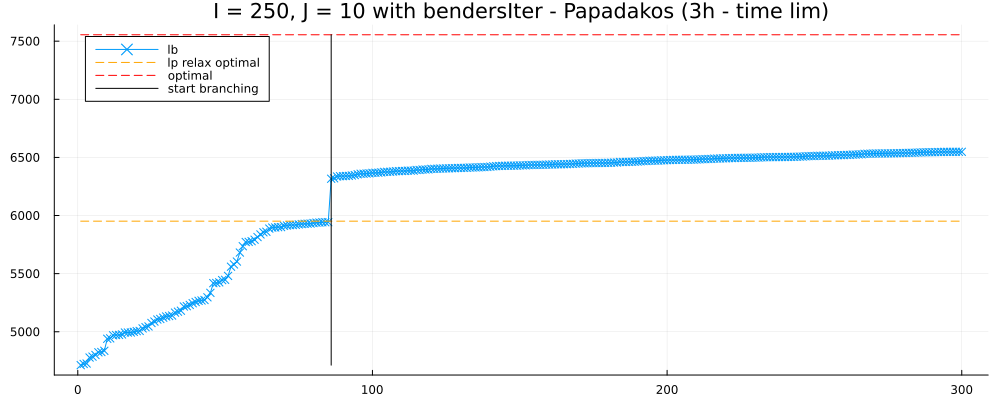

In [322]:
# Instance Own/18_3 with bendersIter
ordered_lb = sort(res[12])
ordered_ub = sort(res[13]);

of_val = 7555.2078
of_val_rel = 5951.6929
gaps = [10e-3, 5e-2, 10e-2]#, round(abs(of_val-ordered_lb[res[end-1]])/of_val,digits=2)]
refs = [of_val*(1-i) for i in gaps]
plot(1:status.nIter, collect(values(ordered_lb)), label="lb",
    size=(1000,400), markershape=:xcross, legend=:topleft)

# LP relaxation optimal
plot!(1:status.nIter, zeros(status.nIter).+of_val_rel, label="lp relax optimal", color=:orange, linestyle = :dash)
# Optimal
plot!(1:status.nIter, zeros(status.nIter).+of_val, label="optimal", color=:red, linestyle = :dash)
# Gaps
# for i in 1:length(gaps)
#     gap = gaps[i]
#     plot!(1:status.nIter, zeros(status.nIter).+refs[i], label=gap, linestyle = :dash)
# end
plot!([res[end-1]+1,res[end-1]+1],[collect(values(ordered_lb))[1],of_val], label="start branching", color=:black)

title!("I = 250, J = 10 with $solve_method - Papadakos (3h - time lim)")

# xlims!(0, 100)

In [122]:
ordered_lb = sort(res[end-1])
ordered_ub = sort(res[end]);
# Instance Own/18_3 with benders_cb
of_val = 7555.2078
of_val_rel = 5070.6749
gaps = [10e-3, 5e-2, 10e-2, round(abs(of_val-last(collect(values(ordered_ub)))/of_val),digits=2)]
refs = [of_val*(1-i) for i in gaps]
plot(1:status.nIter, collect(values(ordered_ub)), label="ub",
    size=(1000,400), markershape=:xcross, legend=:topleft)

# LP relaxation optimal
plot!(1:status.nIter, zeros(status.nIter).+of_val_rel, label="lp relax optimal", color=:orange, linestyle = :dash)
# Optimal
plot!(1:status.nIter, zeros(status.nIter).+of_val, label="optimal", color=:red, linestyle = :dash)
# Gaps
# for i in 1:length(gaps)
#     gap = gaps[i]
#     plot!(1:status.nIter, zeros(status.nIter).+refs[i], label=gap, linestyle = :dash)
# end
# plot!([res[end-1]+1,res[end-1]+1],[collect(values(ordered_lb))[1],of_val], label="start branching", color=:black)

title!("I = 250, J = 10 with $solve_method - Papadakos (163 s)")

xlims!(0, 100)

LoadError: MethodError: no method matching sort(::Int64)

[0mClosest candidates are:
[0m  sort([91m::BenchmarkTools.Trial[39m)
[0m[90m   @[39m [35mBenchmarkTools[39m [90mC:\Users\m_hoyo\.julia\packages\BenchmarkTools\QNsku\src\[39m[90m[4mtrials.jl:55[24m[39m
[0m  sort([91m::OrderedCollections.LittleDict[39m; byvalue, args...)
[0m[90m   @[39m [35mOrderedCollections[39m [90mC:\Users\m_hoyo\.julia\packages\OrderedCollections\9C4Uz\src\[39m[90m[4mdict_sorting.jl:38[24m[39m
[0m  sort([91m::AbstractUnitRange[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mrange.jl:1410[24m[39m
[0m  ...


In [ ]:
# Instance Own/6
of_val = 1914.4834
gaps = [10e-3, 5e-2, 10e-2, round(abs(of_val-ordered_lb[res[end-1]])/of_val,digits=2)]
refs = [of_val*(1-i) for i in gaps]
plot(1:status.nIter, collect(values(ordered_lb)), label="lb",
    size=(1000,400), markershape=:xcross)
plot!(1:status.nIter, collect(values(ordered_ub)), label="ub", markershape=:xcross)
# ylims!(1500, 4000)
# Optimal
plot!(1:status.nIter, zeros(status.nIter).+of_val, label="optimal", color=:red, linestyle = :dash, lw=1)
# Gaps
for i in 1:length(gaps)
    gap = gaps[i]
    plot!(1:status.nIter, zeros(status.nIter).+refs[i], label=gap, linestyle = :dash, lw=1)
    annotate!(status.nIter, refs[i], text("$gap", :left, 12, :black))
end
plot!([res[end-1]+1,res[end-1]+1],[collect(values(ordered_lb))[1],of_val], label="start branching", color=:black)

title!("I = 20, J = 3")

In [ ]:
plot(1:status.nIter, [collect(values(ordered_lb)) collect(values(ordered_ub))], label=["lb" "ub"],
    size=(1000,400), markershape=:xcross)
# ylims!(1500, 4000)
plot!(1:status.nIter, zeros(status.nIter).+1914.4834) #3649.0341)

In [ ]:
# Own 9
lazy_cuts: of=1914.4834, of_term1=660.1081, of_term2=828.7458, of_term3=425.6295, y=Any[5, 3, 0], CPU_t=0.234
benders: of=1959.8316, of_term1=801.0565, of_term2=858.3784, of_term3=300.3967, y=Any[5, 5, 0], CPU_t=0.141, nodes=3,
        feas=0, opt=40

# Own 8
benders: of=5510.3143, of_term1=1661.3185, of_term2=2132.8105, of_term3=1716.1852, y=Any[1, 0, 0, 0, 1, 5, 4, 0, 4, 0], CPU_t=6.312, nodes=6936,
        feas=21, opt=243
lazy_cuts: of=3649.0341, of_term1=1705.6408, of_term2=1523.3316, of_term3=420.0617, y=Any[0, 0, 0, 0, 3, 4, 4, 4, 0, 5], CPU_t=31.703



In [ ]:
x=[-3.6979166666666665 4.697916666666666 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0; 0.0 1.0 0.0; 0.0 0.0 1.0; 1.0 0.0 0.0; 0.0 0.0 1.0; 0.0 1.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0; 1.0 0.0 0.0; 0.0 0.0 1.0; 0.0 0.0 1.0; 0.0 0.0 1.0; 1.0 0.0 0.0; 0.0 -9.634408602150538 10.634408602150538; 0.0 0.0 1.0; 0.0 1.0 0.0; 0.0 0.0 1.0; 1.0 0.0 0.0]

In [ ]:
lazy_cuts: of=895.9974, of_term1=394.1035, of_term2=501.3773, of_term3=0.5166, y=Any[1, 1, 3], CPU_t=1.375

benders: of=949.9676, of_term1=448.7567, of_term2=501.0648, of_term3=0.1462, y=Any[1, 1, 5], CPU_t=0.249, nodes=17,
        feas=15, opt=30

In [ ]:
y = [-0.0 -0.0 -0.0 -0.0 -0.0; -0.0 -0.0 -0.0 -0.0 -0.0; -0.0 -0.0 -0.0 -0.0 -0.0]
x = [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0; 0.0 1.0 0.0; 0.0 0.0 1.0; 1.0 0.0 0.0; 0.0 0.0 1.0; 0.0 1.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0; 1.0 0.0 0.0; 0.0 0.0 1.0; 0.0 0.0 1.0; 0.0 0.0 1.0; 1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0; 0.0 1.0 0.0; 0.0 0.0 1.0; 1.0 0.0 0.0];

In [ ]:
dot(data0.F, y)

In [ ]:
sum(data0.C[i,j,t]*x[i,j] for i in 1:data0.I for j in 1:data0.J)

In [ ]:
# C1
for j in 1:data0.J
    println("$j: $(-sum(data0.a[i,t]*x[i,j] for i in 1:data0.I)) >= $(-sum(data0.Q[j,k]*y[j,k] for k in 1:data0.k))")
end

In [ ]:
for j in 1:data0.J
    println("$j: $(sum(data0.a[i,t]*x[i,j] for i in 1:data0.I))")
end

In [ ]:
# Pi 1 a 12
benders: of=604.2782, of_term1=0.0, of_term2=604.2775, of_term3=0.0008, y=Any[0, 0, 0], CPU_t=2.672, nodes=1,
        feas=0, opt=15
# Pi 9
benders: of=1130.4119, of_term1=0.0, of_term2=1130.4144, of_term3=-0.0024, y=Any[0, 0, 0], CPU_t=2.297, nodes=0,
        feas=15, opt=0

In [ ]:
# 600 new valid inequality
benders: of=74561.0501, of_term1=23586.6244, of_term2=50953.9516, of_term3=20.4741, y=Any[0, 0, 5, 5, 5, 5, 1, 0, 0, 0], CPU_t=8.249, nodes=2048,
        feas=0, opt=471
bendersWS: of=74561.0434, of_term1=23586.6182, of_term2=50953.9944, of_term3=20.4309, y=Any[0, 0, 5, 5, 5, 5, 1, 0, 0, 0], CPU_t=6.421, nodes=3282,
        feas=0, opt=391
bendersMW: of=74561.0482, of_term1=23586.6244, of_term2=50953.9304, of_term3=20.4934, y=Any[0, 0, 5, 5, 5, 5, 1, 0, 0, 0], CPU_t=17.235, nodes=874,
        feas=0, opt=618
bendersPK: of=74561.0467, of_term1=23586.6244, of_term2=50953.9454, of_term3=20.4769, y=Any[0, 0, 5, 5, 5, 5, 1, 0, 0, 0], CPU_t=5.829, nodes=871,
        feas=0, opt=611
bendersSH: of=74560.9944, of_term1=23586.6246, of_term2=50953.8125, of_term3=20.5574, y=Any[0, 0, 5, 5, 5, 5, 1, 0, 0, 0], CPU_t=6.906, nodes=3031,
        feas=0, opt=578
bendersFC: of=74561.0496, of_term1=23586.6244, of_term2=50953.9287, of_term3=20.4965, y=Any[0, 0, 5, 5, 5, 5, 1, 0, 0, 0], CPU_t=7.344, nodes=855,
        feas=0, opt=189

# No new VI
benders: of=74561.0501, of_term1=23586.6243, of_term2=50953.9091, of_term3=20.5168, y=Any[0, 0, 5, 5, 5, 5, 1, 0, 0, 0], CPU_t=5.828, nodes=5700,
        feas=0, opt=548
bendersWS: of=74561.0497, of_term1=23586.6246, of_term2=50953.8344, of_term3=20.5907, y=Any[0, 0, 5, 5, 5, 5, 1, 0, 0, 0], CPU_t=7.844, nodes=5364,
        feas=0, opt=561
bendersMW: of=74561.0501, of_term1=23586.6245, of_term2=50953.9612, of_term3=20.4644, y=Any[0, 0, 5, 5, 5, 5, 1, 0, 0, 0], CPU_t=10.719, nodes=1572,
        feas=0, opt=470
bendersPK: of=74561.0506, of_term1=23586.6244, of_term2=50953.9611, of_term3=20.4652, y=Any[0, 0, 5, 5, 5, 5, 1, 0, 0, 0], CPU_t=6.687, nodes=1203,
        feas=0, opt=629
bendersSH: of=74560.9951, of_term1=23586.6245, of_term2=50953.832, of_term3=20.5386, y=Any[0, 0, 5, 5, 5, 5, 1, 0, 0, 0], CPU_t=10.155, nodes=5851,
        feas=0, opt=870
bendersFC: of=74561.0501, of_term1=23586.6244, of_term2=50953.9124, of_term3=20.5133, y=Any[0, 0, 5, 5, 5, 5, 1, 0, 0, 0], CPU_t=11.922, nodes=1040,
        feas=3, opt=222

In [ ]:
# 253
benders: of=2136.2163, of_term1=761.9652, of_term2=1370.4704, of_term3=3.7807, y=Any[1, 0, 0, 0, 0, 5, 5, 0, 5, 0], CPU_t=5.125
bendersWS: of=2136.2164, of_term1=761.9652, of_term2=1370.4708, of_term3=3.7804, y=Any[1, 0, 0, 0, 0, 5, 5, 0, 5, 0], CPU_t=7.782
bendersMW: of=2136.2163, of_term1=761.9652, of_term2=1370.4711, of_term3=3.78, y=Any[1, 0, 0, 0, 0, 5, 5, 0, 5, 0], CPU_t=27.078
bendersPK: of=2136.2163, of_term1=761.9652, of_term2=1370.4725, of_term3=3.7786, y=Any[1, 0, 0, 0, 0, 5, 5, 0, 5, 0], CPU_t=4.36
bendersSH: of=2136.2154, of_term1=761.9652, of_term2=1370.4701, of_term3=3.7801, y=Any[1, 0, 0, 0, 0, 5, 5, 0, 5, 0], CPU_t=6.938
bendersFC: of=2136.2157, of_term1=761.9652, of_term2=1370.4698, of_term3=3.7807, y=Any[1, 0, 0, 0, 0, 5, 5, 0, 5, 0], CPU_t=8.531

In [ ]:
# 600
benders: of=74561.0501, of_term1=23586.6243, of_term2=50953.8793, of_term3=20.5466, y=Any[0, 0, 5, 5, 5, 5, 1, 0, 0, 0], CPU_t=4.531
bendersWS: of=74561.0489, of_term1=23586.6242, of_term2=50953.9102, of_term3=20.5145, y=Any[0, 0, 5, 5, 5, 5, 1, 0, 0, 0], CPU_t=5.64
bendersPK: of=74561.0492, of_term1=23586.6244, of_term2=50953.9351, of_term3=20.4897, y=Any[0, 0, 5, 5, 5, 5, 1, 0, 0, 0], CPU_t=7.265
bendersSH: of=74560.9948, of_term1=23586.6253, of_term2=50953.9062, of_term3=20.4632, y=Any[0, 0, 5, 5, 5, 5, 1, 0, 0, 0], CPU_t=5.75
bendersFC: of=74561.0505, of_term1=23586.6244, of_term2=50953.9369, of_term3=20.4892, y=Any[0, 0, 5, 5, 5, 5, 1, 0, 0, 0], CPU_t=10.453
bendersMW: of=74561.0493, of_term1=23586.6247, of_term2=50953.9446, of_term3=20.4799, y=Any[0, 0, 5, 5, 5, 5, 1, 0, 0, 0], CPU_t=12.843

In [ ]:
# OF mp, OF sum
res[1], res[2]

In [ ]:
# 74.561.0497
res[3]+ res[4] + res[5]

In [ ]:
res[3], res[4] , res[5]

In [ ]:
#235
res[9], res[10], res[11]

In [ ]:
#600
res[9], res[10], res[11]

In [ ]:
#600
res[9], res[10], res[11]

In [ ]:
#235
res[9], res[10], res[11]

In [ ]:
#235
res[9], res[10], res[11]

In [ ]:
#235
res[9], res[10], res[11]

In [ ]:
#235
res[9], res[10], res[11]

In [ ]:
# 404
res[9], res[10], res[11]

In [ ]:
#130 
lazy_cuts: of=895.9974, of_term1=394.1035, of_term2=501.3766, of_term3=0.5173, y=Any[1, 1, 3], CPU_t=0.046
benders: of=895.9974, of_term1=394.1035, of_term2=501.3747, of_term3=0.5191, y=Any[1, 1, 3], CPU_t=0.157
# 200
lazy_cuts: of=2301.6885, of_term1=1333.1643, of_term2=966.8477, of_term3=1.6765, y=Any[0, 0, 4, 5, 0, 0, 0, 1, 4, 1], CPU_t=11.296
benders: of=2301.6881, of_term1=1333.1643, of_term2=966.8512, of_term3=1.673, y=Any[0, 0, 4, 5, 0, 0, 0, 1, 4, 1], CPU_t=8.094
#235
nlp: of=2136.2173, of_term1=761.9652, of_term2=1370.498, of_term3=3.754, y=Any[1, 0, 0, 0, 0, 5, 5, 0, 5, 0], CPU_t=43.626
lazy_cuts: of=2136.2164, of_term1=761.9652, of_term2=1370.4727, of_term3=3.7785, y=Any[1, 0, 0, 0, 0, 5, 5, 0, 5, 0], CPU_t=3.532
lazy_cuts: of=2136.2163, of_term1=761.9652, of_term2=1370.4722, of_term3=3.7789, y=Any[1, 0, 0, 0, 0, 5, 5, 0, 5, 0], CPU_t=10.0
benders: of=2136.2154, of_term1=761.9652, of_term2=1370.4699, of_term3=3.7811, y=Any[1, 0, 0, 0, 0, 5, 5, 0, 5, 0], CPU_t=2.953
bendersSH: of=2076.9208, of_term1=761.9652, of_term2=1313.2436, of_term3=1.7122, y=Any[1, 0, 0, 0, 0, 5, 5, 0, 5, 0], CPU_t=2.937

# 404
lazy_cuts: of=6473.8752, of_term1=5017.8601, of_term2=1441.3593, of_term3=14.6558,
y=Any[5, 0, 0, 0, 0, 5, 0, 0, 5, 0, 0, 0, 5, 1, 0, 0, 5, 0, 5, 0, 5, 0, 5, 0, 0, 5, 
    5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 0, 0, 5, 0, 0, 0, 0, 0, 5, 0, 4], CPU_t=469.5

benders: of=6312.4219, of_term1=4879.4955, of_term2=1466.0399, of_term3=454.4843,
y=Any[5, 0, 0, 0, 0, 5, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0, 5, 0, 5, 0, 5, 0, 5, 0, 0, 5,
    5, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 0, 0, 5, 0, 0, 0, 0, 0, 5, 0, 5], CPU_t=2559.781

In [ ]:
xlc = res[7]
ylc = res[6];

In [ ]:
xben = res[7]
yben = res[6];

In [ ]:
# Are equal?
xben == xlc

In [ ]:
# Assignation cost
dot(data0.C,xben[:,:,:]), dot(data0.C,xlc[:,:,:])

In [ ]:
t=1

In [ ]:
# Demand per facility Bend
demben = sum(data0.a[:,t] .* xben[:,:,t], dims = 1)

In [ ]:
# Cap available Benders
capben = sum(data0.Q .* SSD.gen_y(data0,yben), dims=2)'

In [ ]:
demben .<= capben

In [ ]:
# Demand per facility Lazy Cuts
demlc = sum(data0.a[:,t] .* xlc[:,:,t], dims = 1)

In [ ]:
# Cap available Lazy
caplc = sum(data0.Q .* SSD.gen_y(data0,ylc), dims=2)'

In [ ]:
demlc .<= caplc

In [ ]:
ini_ρ_h = collect(range(0.1,step=0.1,0.9))
H = 1:length(ini_ρ_h)
ρ_h = Array{Float64}(undef,data0.J,data0.t,length(ini_ρ_h))

for j in 1:data0.J, t in 1:data0.t, h in H
    ρ_h[j, t, h]= ini_ρ_h[h]
end

# Are all the methods correct?

See if the x are feasibles

In [ ]:
SSD.gen_y(data0, res[6])

In [ ]:
sum(data0.Q .* SSD.gen_y(data0, res[6]), dims=2)

In [ ]:
t = 1
mat = data0.a[:,t] .* res[7].data[:,:,t]
# mat = data0.a[:,t] .* res[7][:,:,t]
sum(mat, dims=1)

In [ ]:
# X benders
x_benders = res[7]

In [ ]:
# X lazy cuts
x_lazy_cuts = res[7].data

In [ ]:
# X lazy cuts vs benders
t = 3
x_lazy_cuts[:,:,t].==x_benders[:,:,t]

In [ ]:
x_lazy_cuts[:,:,t]

In [ ]:
x_benders[:,:,t]

In [ ]:
# Iterative cuts

In [ ]:
sum(data0.Q .* SSD.gen_y(data0, res[9]), dims=2)

In [ ]:
t = 1
mat = data0.a[:,t] .* res[10].data[:,:,t]
sum(mat, dims=1)

In [ ]:
repeat(["Own"],4)

# Solver several instances for several methods

In [ ]:
directory = "instances/Own/"
filename="130.txt"
"""
Type    I    J
Own
130     20   3
235     50   10
404     70   50

p-med
600     90   10    
"""

# instances = ["instances/Own/130.txt", "instances/Own/235.txt", "instances/Own/404.txt", "instances/p-med/550.txt"]
instances = ["130.txt", "235.txt", "404.txt", "600.txt"]
instances = ["13.txt","14.txt","15.txt","16.txt","17.txt","18.txt"]
instances = ["18_3.txt"] #, "18_2.txt", "18_3.txt"]
# instances = ["130.txt"]
directories = repeat(["instances/Own/"],length(instances)) #["instances/Own/", "instances/Own/", "instances/Own/"]
results = []
results_benders = []

col_names_res = ["I","J","cv","D","instance","method","of", "FC", "AC", "CC", "y","CPU_t_s", "status"]
push!(results, [i for i in col_names_res])

col_names_benders = ["I","J","cv","D","instance","method","of", "FC", "AC", "CC","y","nodes","f_cut","opt_cut","CPU_t_s", "status"]
push!(results_benders, [i for i in col_names_benders])

for (instance, directory) in zip(instances,directories)

    params0 = SSD.default_params()
    data0 = SSD.default_data()
    
    # Iterate over each instance
    SSD.read_file(directory*instance, data0)
    
    # Define the different cost levels
    cost_levels = [0.60, 0.85, 1, 1.15, 1.35]
    data0.F = SSD.gen_costs(data0, params0, cost_levels)
    # Define the different capacity levels
    cap_levels = [0.5, 0.75, 1, 1.25, 1.5]
    data0.Q = SSD.gen_caps(data0, params0, cap_levels)
    
    for solve_method in ["bendersIter"]#["iter_cuts","lazy_cuts","benders", "bendersPK","bendersIter"]#["iter_cuts","lazy_cuts","benders","bendersWS1","bendersWS2", "bendersMW", "bendersPK", "bendersSH", "bendersFC", "heur_NM", "heur_FB"]#["nlp", "iter_cuts", "lazy_cuts", "benders", "bendersWS","bendersMW", "bendersPK", "bendersSH", "heur_NM", "heur_FB"]#
        println("")
        println("Starting $solve_method")
        status = SSD.init_solver_status()
        try
            el = @CPUelapsed res = SSD.solve_ssd(data0, params0, status, solve_method)
            println("$solve_method: of=$(res[1]), of_term1=$(res[3]), of_term2=$(res[4]), of_term3=$(res[5]), y=$(res[6])")
            if solve_method == "iter_cuts"
                push!(results, (data0.I, data0.J, data0.cv, data0.D, instance, solve_method, ("$(res[1]) - $(res[2])"), ("$(res[3]) - $(res[6])"), ("$(res[4]) - $(res[7])"), ("$(res[5]) - $(res[8])"), "$([i for i in res[9]])", el, res[11]))
            else
                push!(results, (data0.I, data0.J, data0.cv, data0.D, instance, solve_method, res[1], res[3], res[4], res[5], "$([i for i in res[6]])", el, res[8]))
            end
            if solve_method in ["benders", "bendersWS", "bendersMW", "bendersPK", "bendersSH", "bendersFC","bendersIter"]
                push!(results_benders, (data0.I, data0.J, data0.cv, data0.D, instance, solve_method, res[1], res[3], res[4], res[5], "$([i for i in res[6]])", res[9], res[10], res[11], el, res[8]))
            end
        catch e
            push!(results, (data0.I, data0.J, data0.cv, data0.D, instance, solve_method, "error", "", "", "", "", "", ""))
        end
        println(status.endStatus)
    end
end

In [ ]:
ub = 10967.009707
lb = 5096.226159395523 
(ub-lb)/ub

In [ ]:
cols = [collect(results[i]) for i in eachindex(results)]
df_res = DataFrame(cols, [Symbol(i) for i in eachindex(cols)]);
# CSV.write("240802_res_big2.csv", df_res)

In [ ]:
df_res

In [ ]:
df_res

In [ ]:
cols_ben = [collect(results_benders[i]) for i in eachindex(results_benders)]
df_res_ben = DataFrame(cols_ben, [Symbol(i) for i in eachindex(cols_ben)]);
CSV.write("240723_res_ins 8_benders.csv", df_res_ben)

In [ ]:
df_res_ben